## Introduction to Portfolio Construction and Analysis with Python

## Module 1. Analysing returns

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from portfolio_pkg import edhec_risk_kit as erk
from scipy.optimize import minimize

**Learning Objectives**

* Understand fundamentals of returns, multiple sets of returns using vectors
* Understand risk adjusted measures
* Understand non-Gaussian distribution, skewness and kurtosis
* Understand downside risk measures
* Estimate value at risk
* Implement the concepts using the lab sessions

#### **Section 1 - Fundamentals of risk and returns**

##### Fundamentals of returns

Average returns are not a good way to look at how an asset behaves, this is because volatility of the asset is not incorporated into this notion of average returns, i.e., we can have a more volatile asset and a less volatile asset whose average monthly returns are the same

<c>![Two asset returns](images/two_asset_returns.png)</c>

Just because the average monthly returns are the same doesn't mean we are going to end up with the same amount of money.

The return from time $t$ to time ${t+1}$ is given by:

$$ R_{t,t+1} = \frac{P_{t+1}-P_{t}}{P_{t}} $$

or alternately

$$ R_{t,t+1} = \frac{P_{t+1}}{P_{t}} - 1 $$

When dealing with stocks, if we want to compute the total return, we should add the money that we got as a dividend:

$$ R_{t,t+1} = \frac{P_{t+1}+D_{t,t+1}-P_{t}}{P_{t}} $$

If we don't include the dividends in the returns calculation we call that price returns and including the dividends, we call those total returns. **We always want to use total returns for performance analysis**

**Multi period returns** 

<c>![Multiperiod returns](images/multiperiod_returns.png)</c>

$$R_{t, t+2} = (1+R_{t,t+1})(1+R_{t+1,t+2}) - 1 $$

**Example:** you buy a stock that returns 10% on the first day then returs -3% on the second day.

Compounded return will just be: 

$$ 
(1+0.10)(1-0.03)-1 
$$ 



In [3]:
round((1+0.10)*(1-0.03)-1, 3)

0.067

**Anualizing returns:** This is a useful process to compare returns across different periods of time i.e., comparing a monthly return with quarterly or a daily return. The anualized return is nothing more than the return you'll get if the return that you're looking at had continued for a year. 

**Example:** the return over the month is 1%. What's the annualized return? 

$$ 
\cancel{12 * 1\% = 12\%}
$$ 

$$ 
(1+0.01)^{12} - 1 = 12.68\% 
$$ 

In [5]:
# A stock gains 1% over a quarter (i.e. a 3 month period). What's the annualized return?

(1+0.01)**4 - 1 # The return is (1+0.01)^4-1, since there are 4 quarters in a year

0.040604010000000024

##### Lab Session - Basics of Returns

In this lab we'll work the very basics of Returns - computing returns, and compounding a sequence of returns.

Let's start with a set of prices for a stock "A", in a python list:

In [6]:
prices_a = [8.70, 8.91, 8.71]

In [7]:
prices_a[1:]

[8.91, 8.71]

In [8]:
prices_a[:-1]

[8.7, 8.91]

However, since Python lists do not operate as vectors, that will not work, generating an error about "/" not working for lists.

In [9]:
prices_a[1:]/prices_a[:-1] - 1

TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [10]:
prices_a = np.array(prices_a)

In [11]:
prices_a[1:]/prices_a[:-1] - 1

array([ 0.02413793, -0.02244669])

Now, let's add a few more days of prices and introduce a second stock. Let's call these two stocks "Blue" and "Orange". Instead of using raw numpy arrays, we are going to use the far more powerful Pandas DataFrame.

In [12]:
prices = pd.DataFrame({
    'Blue': [8.70, 8.91, 8.71, 8.43, 8.73],
    'Orange': [10.66, 11.08, 10.71, 11.59, 12.11]
})

In [13]:
prices

,Blue,Orange
0,8.70,10.66
1,8.91,11.08
2,8.71,10.71
3,8.43,11.59
4,8.73,12.11


In [14]:
prices.iloc[1:]

,Blue,Orange
1,8.91,11.08
2,8.71,10.71
3,8.43,11.59
4,8.73,12.11


In [15]:
prices.iloc[:-1]

,Blue,Orange
0,8.70,10.66
1,8.91,11.08
2,8.71,10.71
3,8.43,11.59


**WARNING**

However, because Pandas DataFrames will align the row index (in this case: 0, 1, 2, 3, 4) the exact same code fragment will not work as you might expect.

In [16]:
prices.iloc[1:] / prices.iloc[:-1] - 1

,Blue,Orange
0,NaN,NaN
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,NaN,NaN


We can instead use the method `.values` to convert the DataFrame and just pull the values out to a numpy array/matrix

In [17]:
prices.iloc[1:].values / prices.iloc[:-1] - 1

,Blue,Orange
0,0.024138,0.039400
1,-0.022447,-0.033394
2,-0.032147,0.082166
3,0.035587,0.044866


Another way to do it: we can use the pandas method ``shift()``

In [18]:
prices / prices.shift(1) - 1

,Blue,Orange
0,NaN,NaN
1,0.024138,0.039400
2,-0.022447,-0.033394
3,-0.032147,0.082166
4,0.035587,0.044866


Pandas has already a built-in method to do this, called ``pct_change()``

In [19]:
prices.pct_change()

,Blue,Orange
0,NaN,NaN
1,0.024138,0.039400
2,-0.022447,-0.033394
3,-0.032147,0.082166
4,0.035587,0.044866


In [21]:
prices = pd.read_csv('../../data/sample_prices.csv')
prices

,BLUE,ORANGE
0,8.7000,10.6600
1,8.9055,11.0828
2,8.7113,10.7100
3,8.4346,11.5907
4,8.7254,12.1070
5,9.0551,11.7876
6,8.9514,11.2078
7,9.2439,12.5192
8,9.1276,13.3624
9,9.3976,14.4080


In [22]:
returns = prices.pct_change()
returns

,BLUE,ORANGE
0,NaN,NaN
1,0.023621,0.039662
2,-0.021807,-0.033638
3,-0.031763,0.082232
4,0.034477,0.044544
5,0.037786,-0.026381
6,-0.011452,-0.049187
7,0.032676,0.117008
8,-0.012581,0.067353
9,0.029581,0.078249


<Axes: >

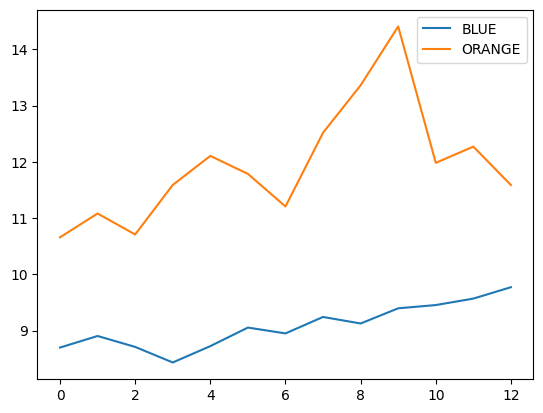

In [23]:
prices.plot()

<Axes: >

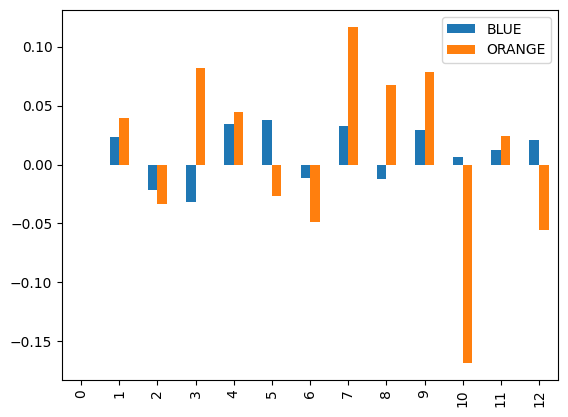

In [24]:
returns.plot.bar()

Computing the standard deviation of these assets

In [25]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

In [26]:
returns.mean()

BLUE      0.01
ORANGE    0.01
dtype: float64

In [28]:
np.prod(returns + 1, axis=0) - 1

BLUE      0.123310
ORANGE    0.087167
dtype: float64

In [29]:
(returns + 1).prod() - 1

BLUE      0.123310
ORANGE    0.087167
dtype: float64

**Annualization**

In [30]:
rm = 0.01
(1 + rm) ** 12

1.1268250301319698

In [31]:
rq = 0.04
(1 + rq) ** 4

1.1698585600000002

In [32]:
rd = 0.0001
(1 + rd) ** 252

1.0255189119876946

##### Measures of risk and reward

We compute the **average of the square** of the deviations from the mean. This measure is called variance and is computed as follows:

$$\sigma_{R}^2 = \frac{1}{N} \sum_{i=1}^{N} {(R_i - \bar{R})^2}$$

Where $\bar{R}$ is the arithmetic mean of the returns. 

The variance of a set of returns is nothing more than the average of the square of the deviations from its mean.

The standard deviation is given by:

$$\sigma_{R} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} {(R_i - \bar{R})^2}}$$

**Annualizing volatility**

We can't compare the volatility from daily data with the volatility from monthly data. For that we have to annualize volatility, and we do it the following way:

$$\sigma^2_{ann} = p\sigma^2_{p}$$
$$\sigma_{ann} = \sigma_{p}\sqrt{p}$$

There are approximately 252 trading days per calendar year

**Example** The standard deviation of a stock's daily return series is $0.1\%$

$$0.001 \cdot \sqrt{252} = 1.58\% $$

**Risk Adjusted Measures** 

<c>![Large cap returns vs small cap returns](images/stock_returns_small_large.png)</c>

The blue line are US small caps, and the red line are US large caps. How do we compare these two? One way to think it about it is to simply compute the ratio, how much return did I get per unit risk?

That's called the return on risk ratio. 

We should look at its excess return over the risk free rate

$$ Return\: on\: Risk\: Ratio = \frac{Return}{Volatility}$$

$$ Sharpe\: Ratio = \frac{Return\: -\: risk\: free\: rate}{Volatility}$$

$$ Sharpe\: Ratio(P) = \frac{R_p-R_f}{\sigma_p}$$

##### Lab Session - Risk Adjusted Returns

We've seen that the volatility is measured by the average squared deviation from the mean, which is the standard deviation.

Let's read the sample returns that we've been working with.

In [34]:
prices = pd.read_csv('../../data/sample_prices.csv')

returns = prices.pct_change()
returns

,BLUE,ORANGE
0,NaN,NaN
1,0.023621,0.039662
2,-0.021807,-0.033638
3,-0.031763,0.082232
4,0.034477,0.044544
5,0.037786,-0.026381
6,-0.011452,-0.049187
7,0.032676,0.117008
8,-0.012581,0.067353
9,0.029581,0.078249


Notice that the first set of returns are NaN, which is Pandas way of saying that it's an NA. We can drop that row using the `.dropna()` method.

In [35]:
returns = returns.dropna()
returns

,BLUE,ORANGE
1,0.023621,0.039662
2,-0.021807,-0.033638
3,-0.031763,0.082232
4,0.034477,0.044544
5,0.037786,-0.026381
6,-0.011452,-0.049187
7,0.032676,0.117008
8,-0.012581,0.067353
9,0.029581,0.078249
10,0.006151,-0.168261


Let's compute the standard deviation from first principles:

In [36]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

In [ ]:
devations = returns - returns.mean()
squared_deviations = devations ** 2
variance = squared_deviations.sum() / (returns.shape[0] - 1)
volatility = np.sqrt(variance)
volatility

BLUE      0.023977
ORANGE    0.079601
dtype: float64

We annualize volatility by scaling (multiplying) it by the square root of the number of periods per observation

Therefore, to annualize the volatility of a monthly series, we muiltiply it by the square root of 12. Instead of using the `np.sqrt()` we can raise it to the power of $0.5$

In [38]:
# Annualizing it

volatility * np.sqrt(12)

BLUE      0.083060
ORANGE    0.275747
dtype: float64

Let's get beyond the sample data series and start working with some real data. Read in the monthly returns of a set of 10 portfolios formed on market caps, or market equities of the companies. Of the 10 portfolios, we only want to look at the largest cap and the smallest cap companies:

In [39]:
returns = pd.read_csv('../../data/Portfolios_Formed_on_ME_monthly_EW.csv', 
            header=0, index_col=0, parse_dates=True, na_values=-99.99)

C:\Users\JUANJO\AppData\Local\Temp\ipykernel_33644\2149718106.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns = pd.read_csv('../../data/Portfolios_Formed_on_ME_monthly_EW.csv',


In [40]:
returns.head()

,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
192607,NaN,-0.43,1.52,2.68,-0.57,0.59,1.60,1.47,3.33,-1.45,0.29,-0.15,1.33,1.24,1.98,1.55,1.38,3.38,3.29
192608,NaN,3.90,3.04,2.09,3.84,3.59,3.71,1.61,2.33,5.12,2.59,4.03,3.15,2.72,4.72,1.60,1.63,0.98,3.70
192609,NaN,-1.08,-0.54,0.16,-0.48,-1.40,0.00,-0.50,-0.09,0.93,-1.87,-2.27,-0.53,0.07,-0.07,-1.64,0.64,-0.86,0.67
192610,NaN,-3.32,-3.52,-3.06,-3.29,-4.10,-2.89,-3.36,-2.95,-4.84,-1.77,-3.36,-4.83,-2.98,-2.80,-3.45,-3.27,-3.47,-2.43
192611,NaN,-0.46,3.82,3.09,-0.55,2.18,3.41,3.39,3.16,-0.78,-0.32,-0.29,4.65,3.24,3.57,3.82,2.95,3.61,2.70


In [41]:
columns = ['Lo 10', 'Hi 10']

returns = returns[columns]
returns.head()

,Lo 10,Hi 10
192607,-1.45,3.29
192608,5.12,3.70
192609,0.93,0.67
192610,-4.84,-2.43
192611,-0.78,2.70


Note that the data is already given in percentages (i.e 4.5 instead of 0.045) and we typically want to use the actual numbers (i.e. 0.045 instead of 4.5) so we should divide the raw data from the file by 100.

In [42]:
returns = returns / 100
returns.head()

,Lo 10,Hi 10
192607,-0.0145,0.0329
192608,0.0512,0.0370
192609,0.0093,0.0067
192610,-0.0484,-0.0243
192611,-0.0078,0.0270


In [43]:
returns.columns = ['SmallCap', 'LargeCap']
returns.head()

,SmallCap,LargeCap
192607,-0.0145,0.0329
192608,0.0512,0.0370
192609,0.0093,0.0067
192610,-0.0484,-0.0243
192611,-0.0078,0.0270


<Axes: >

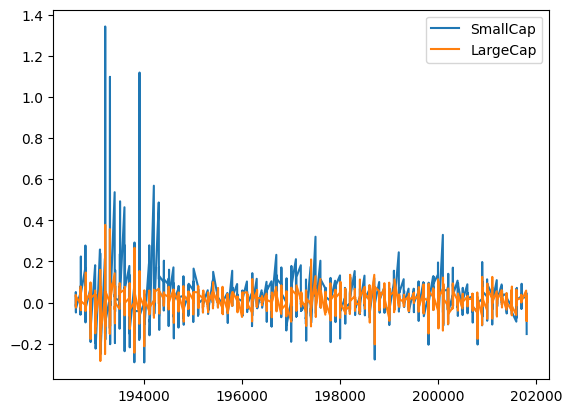

In [44]:
returns.plot.line()

In [45]:
returns.std()

SmallCap    0.106288
LargeCap    0.053900
dtype: float64

In [46]:
annualized_vol = returns.std() * np.sqrt(12)
annualized_vol

SmallCap    0.368193
LargeCap    0.186716
dtype: float64

We can now compute the annualized returns as follows:

In [48]:
n_months = returns.shape[0]
return_per_month = (returns + 1).prod() ** (1 / n_months) - 1
return_per_month

SmallCap    0.012986
LargeCap    0.007423
dtype: float64

In [49]:
annualized_return = (return_per_month + 1) ** 12 - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [50]:
# Another way to compute the annualized return 
annualized_return = (returns + 1).prod() ** (12/n_months) - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [51]:
annualized_return / annualized_vol

SmallCap    0.454825
LargeCap    0.497063
dtype: float64

In [52]:
riskfree_rate = 0.03

excess_return = annualized_return - riskfree_rate

sharpe_ratio = excess_return / annualized_vol
sharpe_ratio

SmallCap    0.373346
LargeCap    0.336392
dtype: float64

**Exercise computing the sharpe ratio taking the smallest 20% vs the largest 20%**

In [54]:
returns = pd.read_csv('../../data/Portfolios_Formed_on_ME_monthly_EW.csv', 
            header = 0, index_col = 0, parse_dates = True, na_values = -99.99)

C:\Users\JUANJO\AppData\Local\Temp\ipykernel_33644\1786914167.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns = pd.read_csv('../../data/Portfolios_Formed_on_ME_monthly_EW.csv',


In [55]:
cols = ['Lo 20', 'Hi 20']
returns = returns[cols]
returns.head()

,Lo 20,Hi 20
192607,-0.57,3.33
192608,3.84,2.33
192609,-0.48,-0.09
192610,-3.29,-2.95
192611,-0.55,3.16


In [56]:
returns = returns / 100 
returns.head()

,Lo 20,Hi 20
192607,-0.0057,0.0333
192608,0.0384,0.0233
192609,-0.0048,-0.0009
192610,-0.0329,-0.0295
192611,-0.0055,0.0316


In [57]:
returns.std()

Lo 20    0.097197
Hi 20    0.056325
dtype: float64

In [58]:
returns.columns = ['SmallCap20', 'LargeCap20']
returns

,SmallCap20,LargeCap20
192607,-0.0057,0.0333
192608,0.0384,0.0233
192609,-0.0048,-0.0009
192610,-0.0329,-0.0295
192611,-0.0055,0.0316
...,...,...
201808,0.0309,0.0249
201809,-0.0204,0.0019
201810,-0.1052,-0.0741
201811,-0.0278,0.0249


<Axes: >

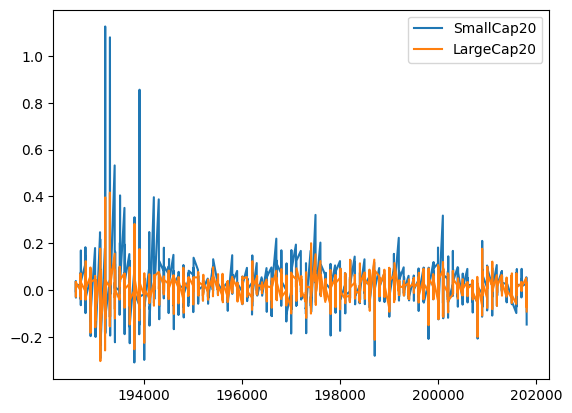

In [59]:
returns.plot.line()

In [60]:
annualized_vol = returns.std() * np.sqrt(12)
annualized_vol

SmallCap20    0.336701
LargeCap20    0.195116
dtype: float64

In [61]:
n_months = returns.shape[0]
annualized_return = (returns + 1).prod() ** (12/n_months) - 1
annualized_return

SmallCap20    0.151977
LargeCap20    0.098490
dtype: float64

In [62]:
annualized_return / annualized_vol

SmallCap20    0.451370
LargeCap20    0.504778
dtype: float64

In [63]:
riskfree_rate = 0.03

excess_return = annualized_return - riskfree_rate
sharpe_ratio = excess_return / annualized_vol
sharpe_ratio

SmallCap20    0.362271
LargeCap20    0.351023
dtype: float64

##### Measuring max drawdown

The max drawdown is the maximum loss from the previous high to a subsequent low. Buy at its highest value - sold at the bottom. The worst possible return you could have seen if you "buy high, sold low"

**Constructing a wealth index** 

1. Computing drawdowns is to construct a wealth index hypothetical buy-and-hold investment in the asset.

![image.png](attachment:image.png)

2. Look at the prior peak at any point in time

![image.png](attachment:image-2.png)

The drawdown is the distance from the green line to the blue line at any given point in time

* Drawdowns are entirely defined by two points and hence are very sensitive to outliers.
* They depend on the frequency of observations, in general, a very deep drawdown on a daily or weekly basis might almost completely dissapear or move to very different location based on monthly data.
* In spite of this shortcomings, drawdowns are closely monitored and popular amongst practicioners even though other measures like VAR and CVAR are more robust measures of extreme risk,

##### Lab Session - Drawdown

In this lab, we'll develop the code to compute the maximum drawdown of a return series, and we'll start to develop our own module which will act as a toolkit that we will add to during the course.

First, let's read the return series we processed in the previous lab:

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10752\3308855969.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  me_m = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv',


<Axes: >

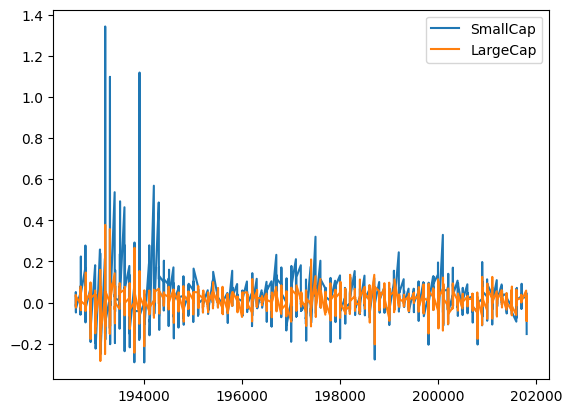

In [ ]:
me_m = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv', 
            header = 0, index_col = 0, parse_dates = True, na_values = -99.99)

columns = ['Lo 10', 'Hi 10']
rets = me_m[columns]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets / 100

rets.plot.line()

In [ ]:
rets.head()

,SmallCap,LargeCap
192607,-0.0145,0.0329
192608,0.0512,0.0370
192609,0.0093,0.0067
192610,-0.0484,-0.0243
192611,-0.0078,0.0270


Timeseries - forcing the index to be a datetime

In [ ]:
# Checking if the index is in datetime format

rets.index

Index([192607, 192608, 192609, 192610, 192611, 192612, 192701, 192702, 192703,
       192704,
       ...
       201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811,
       201812],
      dtype='int64', length=1110)

In [ ]:
rets.index = pd.to_datetime(rets.index, format = '%Y%m')
rets.head()

,SmallCap,LargeCap
1926-07-01,-0.0145,0.0329
1926-08-01,0.0512,0.0370
1926-09-01,0.0093,0.0067
1926-10-01,-0.0484,-0.0243
1926-11-01,-0.0078,0.0270


In [ ]:
# Converting the timestamp to a monthly timestamp

rets.index = rets.index.to_period('M')
rets.head()

,SmallCap,LargeCap
1926-07,-0.0145,0.0329
1926-08,0.0512,0.0370
1926-09,0.0093,0.0067
1926-10,-0.0484,-0.0243
1926-11,-0.0078,0.0270


**Compute Drawdowns**

1. Compute a wealth index
2. Compute previous peaks
3. Compute drawdown - which is the wealth value as a percentage of the previous peak

In [ ]:
wealth_index = 1000 * (1 + rets['LargeCap']).cumprod()
wealth_index.head()

1926-07    1032.900000
1926-08    1071.117300
1926-09    1078.293786
1926-10    1052.091247
1926-11    1080.497711
Freq: M, Name: LargeCap, dtype: float64

<Axes: >

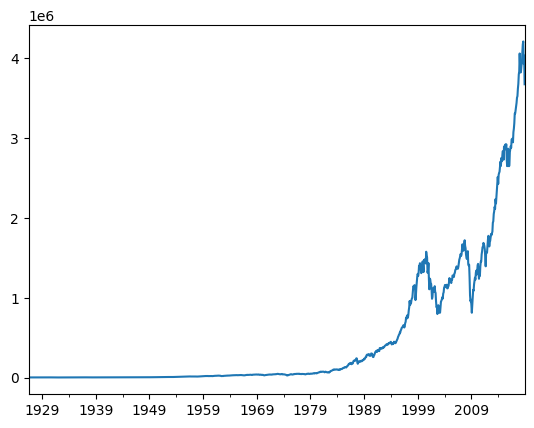

In [ ]:
wealth_index.plot.line()

<Axes: >

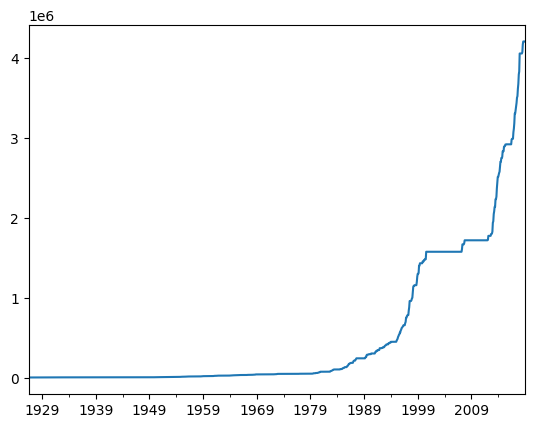

In [ ]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

<Axes: >

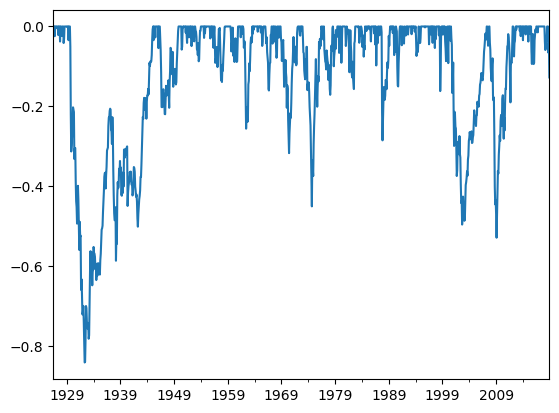

In [ ]:
drawdown = (wealth_index - previous_peaks) / previous_peaks
drawdown.plot()

In the crash of 1929, people lost more than 80% of their wealth. Let's see that deeply

<Axes: >

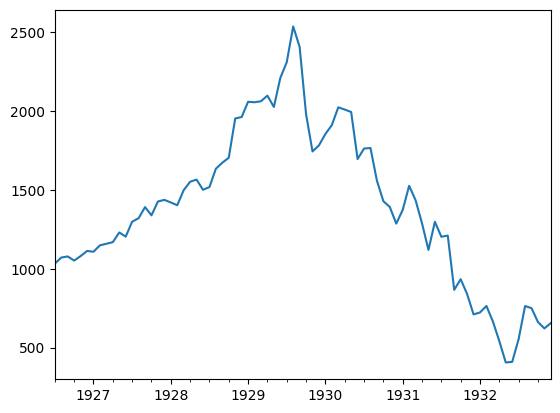

In [ ]:
wealth_index['1926':'1932'].plot()

In [ ]:
drawdown.min()

-0.8400375277943123

In [ ]:
# Computing the maximum drawdown since 1975

drawdown['1975':].min()

-0.5280945042309304

In [ ]:
# If we want to locate when that min happened, we use:

drawdown['1975':].idxmin()

Period('2009-02', 'M')

In [ ]:
drawdown.idxmin()

Period('1932-05', 'M')

**Creating a Drawdown Function**

Redoing this analysis for SmallCap would be tedious, since we would need to re-enter all these commands at the prompt. Instead, let's create our first function that will form the first tool in our financial toolkit.

The function will take as input, a timeseries of returns, and return a timeseries as a DataFrame that contains the wealth index, the previous peaks and the drawdowns as a percent.

In [ ]:
def drawdown(return_series: pd.Series) -> pd.DataFrame :
    '''
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index
    the previous peaks
    percent drawdowns 
    '''

    wealth_index = 1000 * (1 + return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks 

    return pd.DataFrame({
        'Wealth' : wealth_index,
        'Peaks' : previous_peaks,
        'Drawdown' : drawdowns
    })


In [ ]:
drawdown(rets['LargeCap']).head()

,Wealth,Peaks,Drawdown
1926-07,1032.900000,1032.900000,0.0000
1926-08,1071.117300,1071.117300,0.0000
1926-09,1078.293786,1078.293786,0.0000
1926-10,1052.091247,1078.293786,-0.0243
1926-11,1080.497711,1080.497711,0.0000


In [ ]:
drawdown(rets['LargeCap'])[['Wealth', 'Peaks']].head()

,Wealth,Peaks
1926-07,1032.900000,1032.900000
1926-08,1071.117300,1071.117300
1926-09,1078.293786,1078.293786
1926-10,1052.091247,1078.293786
1926-11,1080.497711,1080.497711


<Axes: >

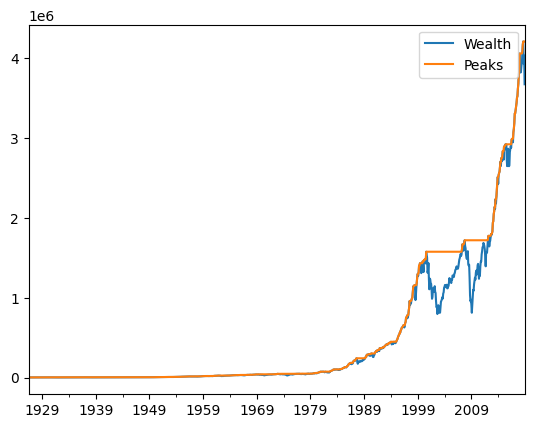

In [ ]:
drawdown(rets['LargeCap'])[['Wealth', 'Peaks']].plot()

<Axes: >

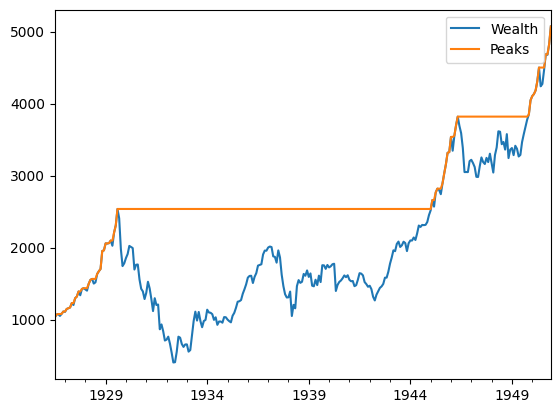

In [ ]:
drawdown(rets[:'1950']['LargeCap'])[['Wealth', 'Peaks']].plot()

In [ ]:
drawdown(rets['LargeCap'])['Drawdown'].min()

-0.8400375277943123

In [ ]:
drawdown(rets['LargeCap'])['Drawdown'].idxmin()

Period('1932-05', 'M')

In [ ]:
drawdown(rets['SmallCap'])['Drawdown'].min()

-0.8330007793945303

In [ ]:
drawdown(rets['SmallCap'])['Drawdown'].idxmin()

Period('1932-05', 'M')

In [ ]:
drawdown(rets['1975':]['LargeCap'])['Drawdown'].min()

-0.5280945042309303

In [ ]:
drawdown(rets['1975':]['LargeCap'])['Drawdown'].idxmin()

Period('2009-02', 'M')

In [ ]:
drawdown(rets['1975':]['SmallCap'])['Drawdown'].min()

-0.6312068077252386

In [ ]:
drawdown(rets['1975':]['SmallCap'])['Drawdown'].idxmin()

Period('2009-02', 'M')